# **Data Process Categorical**
---

# **Imports**

In [18]:
import pandas as pd
import glob
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib

## **File imports**

In [19]:
# folder for txt files
folder = 'qws1_dataset/*.txt'

# list of files
files = glob.glob(folder)

# number of files
count = 1
for file in files:
    print(f'File number {count} - {file}')
    count += 1

File number 1 - qws1_dataset\qws1.txt


In [20]:
# DataFrame creation using files avaiable
df_list = []

for file in files:
    try:
        df_list.append(pd.read_csv(file, sep=','))
    except Exception as e:
        print(f"Skipping {file}: {e}")

if df_list:
    df = pd.concat(df_list, ignore_index=True)
else:
    print("No valid files")

### **Heatmap**

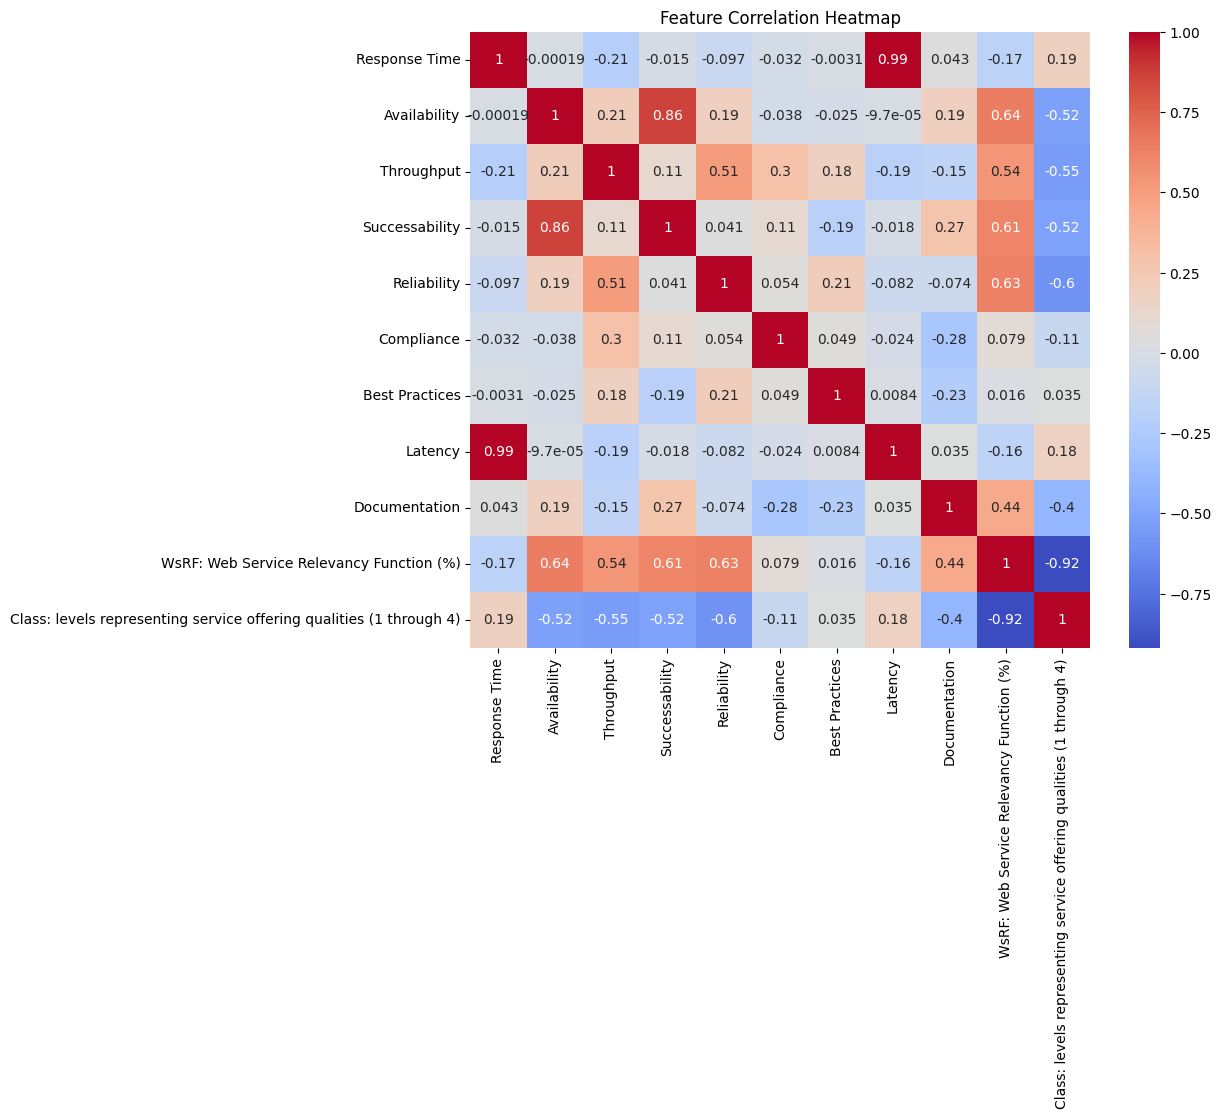

In [21]:
# Correlation Heatmap (numeric columns only)
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Dropping columns that dont add value to the model:
 - Service Name, WSDL Address, Class: levels representing service offering qualities (1 through 4) (target value), WsRF: Web Service Relevancy Function (%) (has negative correlation with target value)

In [22]:
# ============================
# Data Leakage Check
# ============================
# Check correlation of numeric features with target
corr_matrix = df.select_dtypes(include=['number']).corr()
print("Correlation of features with target:")
print(corr_matrix['Class: levels representing service offering qualities (1 through 4)'].sort_values(ascending=False))

Correlation of features with target:
Class: levels representing service offering qualities (1 through 4)    1.000000
Response Time                                                          0.187447
Latency                                                                0.176276
Best Practices                                                         0.034588
Compliance                                                            -0.106655
Documentation                                                         -0.400257
Successability                                                        -0.516015
Availability                                                          -0.524069
Throughput                                                            -0.548563
Reliability                                                           -0.602594
WsRF: Web Service Relevancy Function (%)                              -0.918824
Name: Class: levels representing service offering qualities (1 through 4), dtype: f

## **Data Scaled**

- Dropped of columns that would put more noise in the model
- Defined target column
- Scaled numeric columns and encoded categorical values

In [ ]:
# Drop non-feature columns and the highly correlated column
drop_cols = ['Service Name', 'WSDL Address', 'Class: levels representing service offering qualities (1 through 4)',
             'WsRF: Web Service Relevancy Function (%)']
feature_cols = [col for col in df.columns if col not in drop_cols]

X = df[feature_cols]
y = df['Class: levels representing service offering qualities (1 through 4)']

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Shape of features:", X_scaled.shape)
print("Classes:", label_encoder.classes_)

Shape of features: (364, 9)
Classes: [1 2 3 4]


## **Train/Test Split**

In [24]:
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,        # 80/20 split
    stratify=y_encoded,   # keep class proportions
    random_state=42       # reproducibility
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Class distribution in train:", {i: sum(y_train == i) for i in set(y_train)})
print("Class distribution in test:", {i: sum(y_test == i) for i in set(y_test)})

Train shape: (291, 9) (291,)
Test shape: (73, 9) (73,)
Class distribution in train: {np.int64(0): np.int64(33), np.int64(1): np.int64(80), np.int64(2): np.int64(96), np.int64(3): np.int64(82)}
Class distribution in test: {np.int64(0): np.int64(8), np.int64(1): np.int64(20), np.int64(2): np.int64(24), np.int64(3): np.int64(21)}


# **Baseline**

In [25]:
# ============================
# Baseline: Majority Class Accuracy
# ============================

# Create a dummy classifier that predicts the most frequent class
baseline_clf = DummyClassifier(strategy='most_frequent')
baseline_clf.fit(X_train, y_train)
baseline_pred = baseline_clf.predict(X_test)

baseline_acc = accuracy_score(y_test, baseline_pred)
print(f"Baseline (Majority Class) Accuracy: {baseline_acc:.4f}")

Baseline (Majority Class) Accuracy: 0.3288


In [26]:
# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}

# Binarize y_test for ROC-AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')

    results[name] = {'Accuracy': acc, 'F1': f1, 'ROC-AUC': roc_auc}

# Display results
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Model', 'Accuracy', 'F1', 'ROC-AUC']
results_df

c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:23:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,F1,ROC-AUC
0,LogisticRegression,0.671233,0.689947,0.924434
1,RandomForest,0.753425,0.785942,0.925615
2,XGBoost,0.753425,0.774633,0.913304


---
# **Hyperparameter**
---

## Random Forest

In [27]:
# Parameter grid for RandomForest
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,                # number of random combinations
    scoring='f1_macro',       # optimize for macro F1
    cv=5,                     # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                 # use all cores
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best Score (CV F1):", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
Best Score (CV F1): 0.7800954470945982


## Logistic Regression

In [28]:
# Parameter grid for LogisticRegression
param_grid_lr = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga']
}

lr = LogisticRegression(max_iter=1000, random_state=42)

lr_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_grid_lr,
    n_iter=10,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1
)

lr_search.fit(X_train, y_train)

print("Best Params (LogisticRegression):", lr_search.best_params_)
print("Best CV F1:", lr_search.best_score_)

Best Params (LogisticRegression): {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}
Best CV F1: 0.8613582892405093


## XGBoost

In [39]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=20,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print("Best Params (XGBoost):", xgb_search.best_params_)
print("Best CV F1:", xgb_search.best_score_)

Best Params (XGBoost): {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Best CV F1: 0.7958550171407208


In [40]:
# ============================
# Cross-Validation for Best Model
# ============================

# Assume best_model is the one with highest F1 from comparison_df
best_model_name = comparison_df.loc[comparison_df['F1'].idxmax(), 'Model']
if best_model_name == 'RandomForest':
    best_model = random_search.best_estimator_
elif best_model_name == 'LogisticRegression':
    best_model = lr_search.best_estimator_
else:
    best_model = xgb_search.best_estimator_

cv_scores = cross_val_score(best_model, X_scaled, y_encoded, cv=5, scoring='f1_macro')
print(f"Cross-validation F1 scores for {best_model_name}: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f}")

Cross-validation F1 scores for XGBoost: [0.66764018 0.84158276 0.82113461 0.79949135 0.55437301]
Mean CV F1: 0.7368


c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c

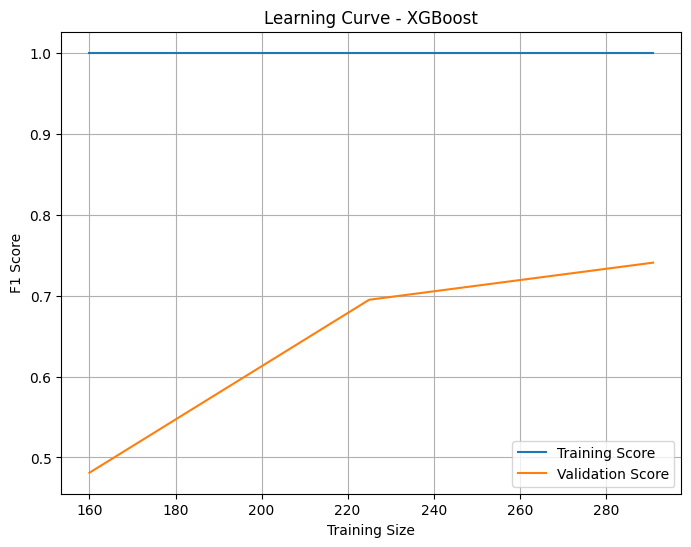

In [31]:
# ============================
# Learning Curve for Best Model
# ============================

train_sizes, train_scores, test_scores = learning_curve(best_model, X_scaled, y_encoded, cv=5, scoring='f1_macro', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.title(f'Learning Curve - {best_model_name}')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

Evaluate Tuned Model

In [ ]:
# Prepare comparison and evaluation
comparison = []
conf_matrices = {}
roc_data = {}

for name, search in [('RandomForest', random_search),
                     ('LogisticRegression', lr_search),
                     ('XGBoost', xgb_search)]:
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    comparison.append([name, acc, f1, roc_auc])

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices[name] = cm

    # Classification Report
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))

    # ROC Curve data
    fpr, tpr, roc_auc_dict = {}, {}, {}
    for i in range(y_test_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
    roc_data[name] = (fpr, tpr, roc_auc_dict)

print("Comparison list:", comparison)

# Summary Table
comparison_df = pd.DataFrame(comparison, columns=['Model', 'Accuracy', 'F1', 'ROC-AUC'])
comparison_df


RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.67      0.70      0.68        20
           2       0.59      0.71      0.64        24
           3       0.93      0.62      0.74        21

    accuracy                           0.70        73
   macro avg       0.74      0.73      0.72        73
weighted avg       0.73      0.70      0.70        73


LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.86      0.60      0.71        20
           2       0.62      0.83      0.71        24
           3       0.87      0.62      0.72        21

    accuracy                           0.73        73
   macro avg       0.75      0.76      0.74        73
weighted avg       0.76      0.73      0.72        73


XGBoost Classification Report:
               p

,Model,Accuracy,F1,ROC-AUC
0,RandomForest,0.698630,0.722706,0.922207
1,LogisticRegression,0.726027,0.735598,0.938765
2,XGBoost,0.753425,0.784859,0.930211


## Visualizations

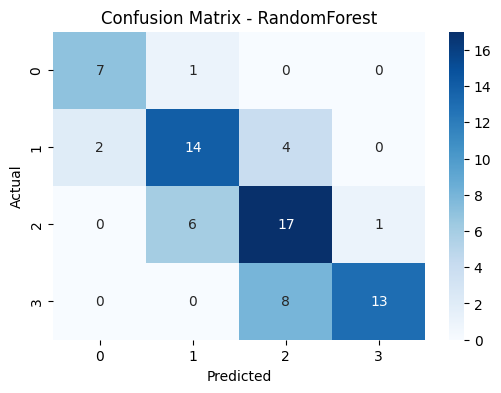

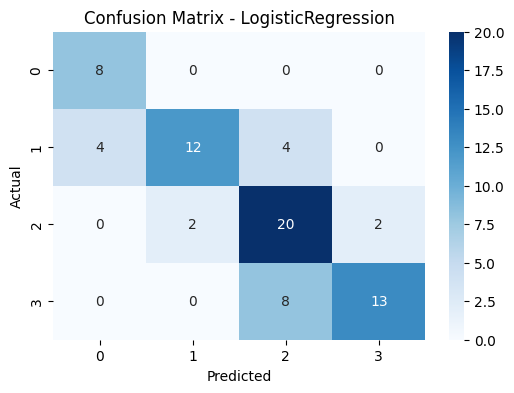

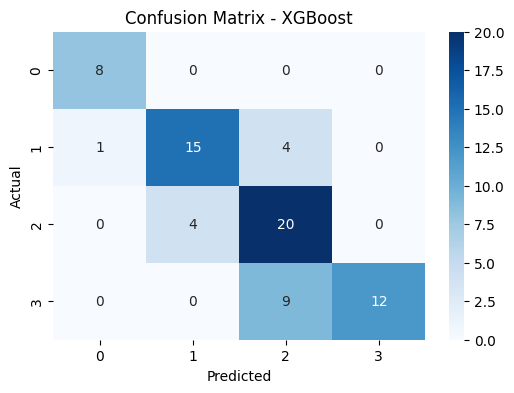

In [33]:
for name, cm in conf_matrices.items():
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

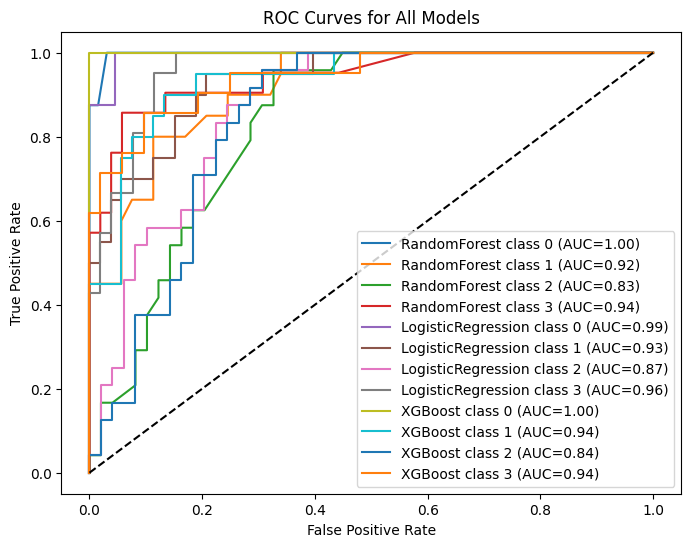

In [34]:
plt.figure(figsize=(8,6))
for name, (fpr, tpr, roc_auc_dict) in roc_data.items():
    for i in range(len(roc_auc_dict)):
        plt.plot(fpr[i], tpr[i], label=f'{name} class {i} (AUC={roc_auc_dict[i]:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.show()

# Interpretability

## Feature Importance

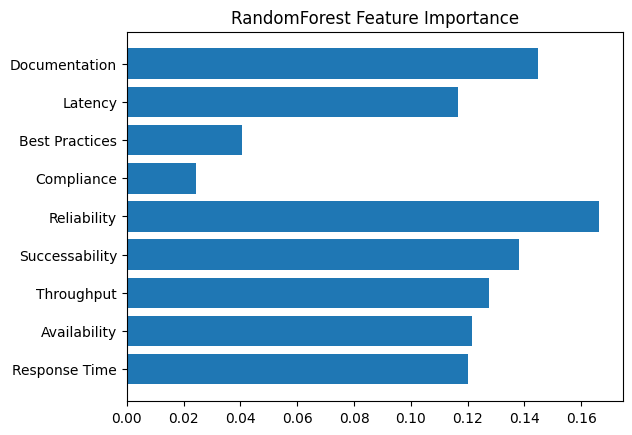

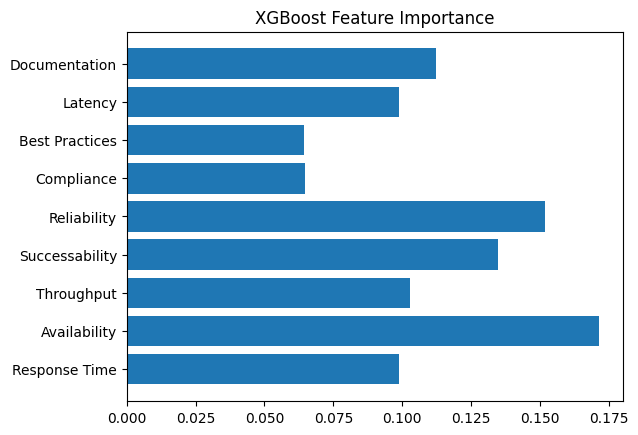

In [35]:
# RandomForest
rf_model = random_search.best_estimator_
importances_rf = rf_model.feature_importances_
plt.barh(feature_cols, importances_rf)
plt.title("RandomForest Feature Importance")
plt.show()

# XGBoost
xgb_model = xgb_search.best_estimator_
importances_xgb = xgb_model.feature_importances_
plt.barh(feature_cols, importances_xgb)
plt.title("XGBoost Feature Importance")
plt.show()

SHAP

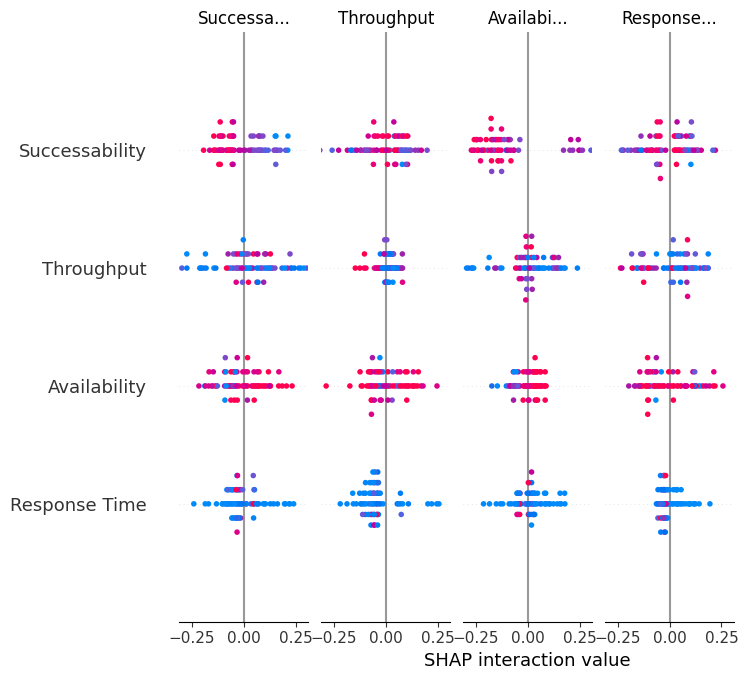

In [36]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

In [37]:
# ============================
# Save Best Model and Scaler
# ============================

joblib.dump(best_model, f'best_model_{best_model_name}.pkl')
joblib.dump(scaler, 'scaler.pkl')
print(f"Saved best model ({best_model_name}) and scaler.")

Saved best model (XGBoost) and scaler.
